<a href="https://colab.research.google.com/github/ChirathD/Tuberculosis/blob/master/TB_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob

import gc
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import tensorflow as tf
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from skimage.segmentation import slic
from keras import backend as K

color = sns.color_palette()
%matplotlib inline

Using TensorFlow backend.


In [2]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chirathd","key":"1cae6df439b65a39bcf2a8f85979946e"}'}

In [0]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kmader/pulmonary-chest-xray-abnormalities

100% 4.08G/4.09G [00:52<00:00, 128MB/s]
100% 4.09G/4.09G [00:53<00:00, 82.5MB/s]


In [7]:
!kaggle datasets download -d yoctoman/shcxr-lung-mask

 51% 5.00M/9.77M [00:00<00:00, 17.3MB/s]
100% 9.77M/9.77M [00:00<00:00, 27.8MB/s]


In [0]:
!mkdir ..//content/segmentation
!mkdir ..//content/segmentation/test
!mkdir ..//content/segmentation/train
!mkdir ..//content/segmentation/train/augmentation
!mkdir ..//content/segmentation/train/image
!mkdir ..//content/segmentation/train/mask
!mkdir ..//content/segmentation/train/dilate
!mkdir ..//content/lung_images
!mkdir ..//content/train
!mkdir ..//content/train/tb_pos
!mkdir ..//content/train/tb_neg

In [0]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [0]:
INPUT_DIR = os.path.join("..", "content")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")
LUNG_IMAGES_DIR = os.path.join(INPUT_DIR, "lung_images")
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TB_POS_DIR = os.path.join(TRAIN_DIR, "tb_pos")
TB_NEG_DIR = os.path.join(TRAIN_DIR, "tb_neg")


In [0]:
!unzip -q -o pulmonary-chest-xray-abnormalities.zip -d pulmonary

In [0]:
!unzip -q -o shcxr-lung-mask.zip -d shcxr

In [13]:
%cd ./pulmonary
%pwd
!ls

/content/pulmonary
ChinaSet_AllFiles.zip  Montgomery.zip


In [0]:
!unzip -q -o Montgomery.zip -d Montgomery

In [0]:
!unzip -q -o ChinaSet_AllFiles.zip -d ChinaSet_AllFiles

In [0]:
!rm Montgomery.zip
!rm ChinaSet_AllFiles.zip

In [17]:
%cd -

/content


In [18]:
%cd ./shcxr
%pwd
!ls

/content/shcxr
mask.zip


In [0]:
!unzip -q -o mask.zip -d mask

In [20]:
%cd -

/content


In [0]:
!rm pulmonary-chest-xray-abnormalities.zip
!rm shcxr-lung-mask.zip

In [22]:

%pwd
!ls

lung_images  pulmonary	sample_data  segmentation  shcxr  train


In [0]:
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, \
                                       "pulmonary")

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR,"ChinaSet_AllFiles", \
                                  "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "shcxr", "mask", "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, \
                                    "Montgomery", "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                        "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                         "ManualMask", "rightMask")


In [0]:
DILATE_KERNEL = np.ones((15, 15), np.uint8)

In [25]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
shenzhen_train= shenzhen_mask_dir[0:]

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file)
        
    #image = cv2.resize(image, (512, 512))
    #mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    lung_image=cv2.bitwise_and(image, mask_dilate)
    
    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
        
        cv2.imwrite(os.path.join(LUNG_IMAGES_DIR, base_file), \
                    lung_image)
        
        
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 566/566 [09:16<00:00,  1.08s/it]


In [26]:
for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)
    
    filename, ext = base_file.split(".")
    s='_'.join(filename.split('_')[-1:])
    #target.append(int(s))  

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file)
        
    #image = cv2.resize(image, (512, 512))
    #mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    lung_image=cv2.bitwise_and(image, mask_dilate)
    lung_image=cv2.resize(lung_image,(299,299))
    
    if (int(s)==0):
      cv2.imwrite(os.path.join(TB_NEG_DIR, base_file), \
                    lung_image)
        
        
    else:
      cv2.imwrite(os.path.join(TB_POS_DIR, base_file), \
                    lung_image)

100%|██████████| 566/566 [02:02<00:00,  4.26it/s]


In [27]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../content"))

['.config', 'shcxr', 'train', 'pulmonary', 'lung_images', 'segmentation', 'sample_data']


In [28]:
image_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.3,shear_range=0.3,zoom_range=0.3, height_shift_range=0.3, horizontal_flip=True, rescale=1./255, validation_split=0.15)  

train_gen = image_datagen.flow_from_directory(TRAIN_DIR, target_size=(224, 224), batch_size=16, class_mode='categorical', subset="training")
valid_gen = image_datagen.flow_from_directory(TRAIN_DIR, target_size=(224, 224), batch_size=16, class_mode='categorical', subset="validation")

Found 482 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


In [0]:
opt = Adam(lr=0.00001, decay=1e-5)

In [0]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    x=Dense(1024, activation='relu')(model.layers[-4].output)# add my own dense layer after the last conv block
    x=Dropout(0.7)(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(2,activation='softmax')(x)
    model=Model(model.input,x)
    
    return model

In [38]:
vgg_conv=vgg16_model(2)
for layer in vgg_conv.layers[:-10]:#freeze all layers except the last ten
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

W0617 17:39:52.466020 139882378241920 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


<keras.engine.input_layer.InputLayer object at 0x7f3839296358> False
<keras.layers.convolutional.Conv2D object at 0x7f3839296240> False
<keras.layers.convolutional.Conv2D object at 0x7f383bb39c18> False
<keras.layers.pooling.MaxPooling2D object at 0x7f383bad42e8> False
<keras.layers.convolutional.Conv2D object at 0x7f383d260e80> False
<keras.layers.convolutional.Conv2D object at 0x7f383d27d7b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f383d227a90> False
<keras.layers.convolutional.Conv2D object at 0x7f383d2270f0> False
<keras.layers.convolutional.Conv2D object at 0x7f383d24f5c0> False
<keras.layers.convolutional.Conv2D object at 0x7f383d1ead30> False
<keras.layers.pooling.MaxPooling2D object at 0x7f383d1fde10> False
<keras.layers.convolutional.Conv2D object at 0x7f383d1fd470> False
<keras.layers.convolutional.Conv2D object at 0x7f383d1b00f0> False
<keras.layers.convolutional.Conv2D object at 0x7f383d1c5c18> False
<keras.layers.pooling.MaxPooling2D object at 0x7f383d15b780>

In [0]:
#inp = Input((224, 224, 3))
#inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp, input_shape=(224, 224, 3), pooling='max')
#x = inception.output
#x = Dense(16, activation='relu')(x)
#x = Dropout(0.5)(x)
#out = Dense(2, activation='softmax')(x)

#complete_model = Model(inp, out)

vgg_conv.compile(optimizer=opt, loss='binary_crossentropy',metrics=['acc'])

In [0]:
history2 = vgg_conv.fit_generator(train_gen, steps_per_epoch=200, epochs=60, validation_data=valid_gen, validation_steps=20, verbose=1)

Epoch 1/60
200/200 [==============================] - 64s 318ms/step - loss: 0.7692 - acc: 0.5813 - val_loss: 0.4999 - val_acc: 0.7958
Epoch 2/60
200/200 [==============================] - 60s 300ms/step - loss: 0.4968 - acc: 0.7744 - val_loss: 0.5019 - val_acc: 0.7817
Epoch 3/60
200/200 [==============================] - 59s 296ms/step - loss: 0.4439 - acc: 0.8122 - val_loss: 0.4994 - val_acc: 0.7721
Epoch 4/60
200/200 [==============================] - 61s 304ms/step - loss: 0.4317 - acc: 0.8059 - val_loss: 0.5475 - val_acc: 0.7394
Epoch 5/60
200/200 [==============================] - 60s 301ms/step - loss: 0.4100 - acc: 0.8269 - val_loss: 0.5257 - val_acc: 0.7535
Epoch 6/60
200/200 [==============================] - 60s 300ms/step - loss: 0.4054 - acc: 0.8256 - val_loss: 0.5072 - val_acc: 0.7390
Epoch 7/60
200/200 [==============================] - 60s 302ms/step - loss: 0.3800 - acc: 0.8334 - val_loss: 0.5314 - val_acc: 0.7430
Epoch 8/60
200/200 [==============================] - 6

In [0]:
from skimage import data, color, io, img_as_float
def get_heatmap(processed_image, class_idx):
    # we want the activations for the predicted label
    class_output = vgg_conv.output[:, class_idx]
    
    # choose the last conv layer in your model
    last_conv_layer = vgg_conv.get_layer('block5_conv3')
    
    # get the gradients wrt to the last conv layer
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    
   # we pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0,1,2))
    
    # Define a function that generates the values for the output and gradients
    iterate = K.function([vgg_conv.input], [pooled_grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = iterate([processed_image])
    
    # iterate over each feature map in your conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(512): # we have 512 features in our last conv layer
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

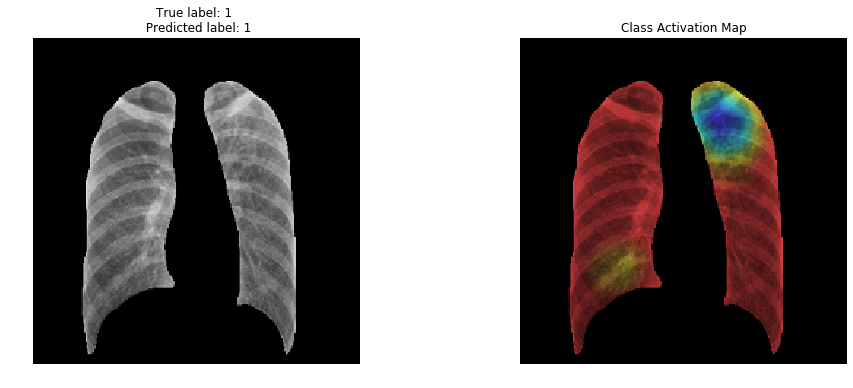

In [333]:
# select the sample and read the corresponding image and label
sample_image = cv2.imread('../content/train/tb_pos/CHNCXR_0600_1.png')
# pre-process the image
sample_image = cv2.resize(sample_image, (224,224))
if sample_image.shape[2] ==1:
            sample_image = np.dstack([sample_image, sample_image, sample_image])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = sample_image.astype(np.float32)/255.
sample_label = 1
    
    
sample_image_processed = np.expand_dims(sample_image, axis=0)#since we pass only one image,we expand dim to include
                                                             #batch size 1
    
# get the label predicted by our original model
pred_label = np.argmax(vgg_conv.predict(sample_image_processed), axis=-1)[0]
    
    
# get the heatmap for class activation map(CAM)
heatmap = get_heatmap(sample_image_processed, pred_label)
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#superimpose the heatmap on the image    

sample_image_hsv = color.rgb2hsv(sample_image)
heatmap = color.rgb2hsv(heatmap)

alpha=0.7
sample_image_hsv[..., 0] = heatmap[..., 0]
sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

img_masked = color.hsv2rgb(sample_image_hsv)

f,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(sample_image)
ax[0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
ax[0].axis('off')
    
ax[1].imshow(img_masked)
ax[1].set_title("Class Activation Map")
ax[1].axis('off')

plt.show()

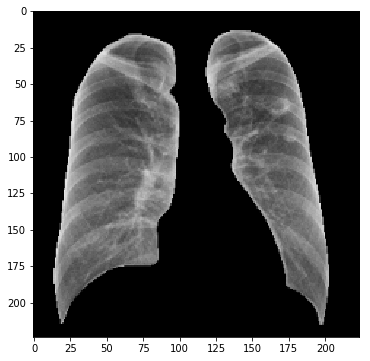

In [90]:
fig = plt.figure(figsize=(16,6))
plt.imshow(img_masked)
plt.imshow(sample_image)
#fig.savefig( "image_333_cam.png")
#files.download("image_333_cam.png")

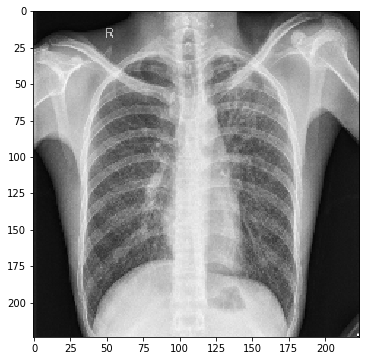

In [334]:
fig = plt.figure(figsize=(16,6))
my_image = cv2.imread('../content/segmentation/train/image/CHNCXR_0600_1.png')
my_image = cv2.resize(my_image, (224,224))
plt.imshow(my_image)
fig.savefig( "image_600_1.png")
files.download("image_600_1.png")

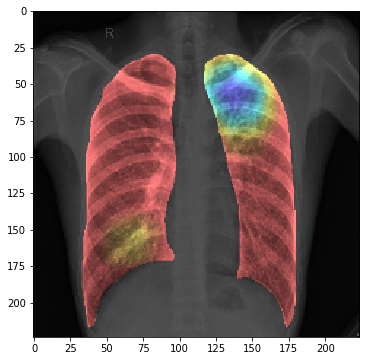

In [337]:
fig = plt.figure(figsize=(16,6))
plt.imshow(cv2.addWeighted(image, 0.99, my_image,0.35,0, new_img))
fig.savefig( "image_600_overlap.png")
files.download("image_600_overlap.png")

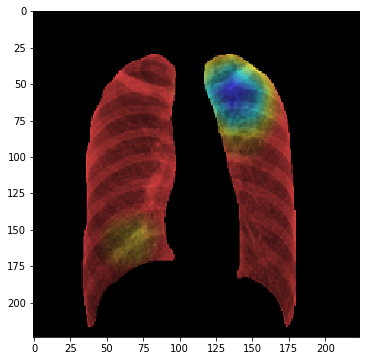

In [338]:
fig = plt.figure(figsize=(16,6))
plt.imshow(img_masked)
fig.savefig( "image_600_seg_lung.png")
files.download("image_600_seg_lung.png")

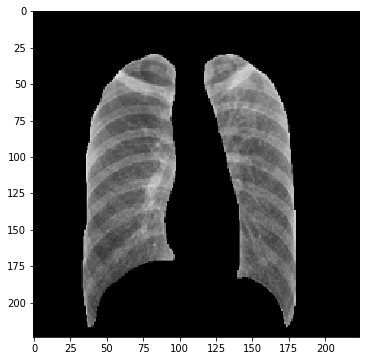

In [339]:
fig = plt.figure(figsize=(16,6))
new_img=cv2.imread('../content/train/tb_pos/CHNCXR_0600_1.png')
new_img = cv2.resize(new_img, (224,224))
plt.imshow(new_img)
fig.savefig( "image_600_seg_normal.png")
files.download("image_600_seg_normal.png")


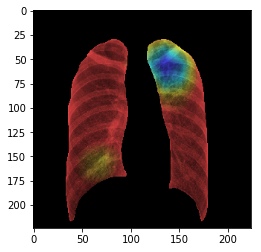

In [336]:
#image = img_masked.astype(np.uint8)
image = (img_masked * 255).round().astype(np.uint8)
plt.imshow(image)
